### Disclaimer
This notebook is intended to help analyzing and monitoring running explorations with chemoton.
It includes checking the current state of the calculations, the development of the number of found compounds over time,
as well as representing reactions as reaction equations and their reactants as graphs.
Furthermore, one can query structures by SMILES and reference `.mol` files to check if certain motivs have been found yet.


Its basic tools are summarized in the `chemoton/scripts/plt_toolbox.py`

#### Setup
Load the necessary packages.

In [1]:
import json
import numpy as np

import plt_toolbox as box

import scine_utilities as utils
import scine_database as db

#### Connect to Database

Given the name of the database, all collections are connected and the toolbox is initiated.
The user has to set the appropiate credentials

In [14]:
#!!!! BEGIN USER INPUT !!!!#
# # # Enter the name of the database # # #
db_name = "BL_Hydrolysis_210201"
credentials = db.Credentials("127.0.0.1", 27017, db_name)
#!!!! END USER INPUT !!!!#

# # # Connect to database
manager = db.Manager()
manager.set_credentials(credentials)
manager.connect()

# # # Get collections of database
structures = manager.get_collection("structures")
calculations = manager.get_collection("calculations")
compounds = manager.get_collection("compounds")
properties = manager.get_collection("properties")
elementary_steps = manager.get_collection("elementary_steps")
reactions = manager.get_collection("reactions")

current_box = box.Toolbox(structures, calculations, compounds, properties, elementary_steps, reactions)

#### Summary of Calculations

Shows a summary in which states your calculations are, when they were created (indicates new reactive complexes) and when they were last touched by a puffin (indicates waiting time for a single calculation).

-------------------Status of Calculations--------------------

                       analyzed               0                
                       complete           38564                
                   construction               0                
                         failed           12853                
                           hold         1104649                
                            new               0                
                        pending               0                
-------------------------------------------------------------
--------------Distribution of new Calculations---------------

                    conformers               0                
                         graph               0                
                    scine_afir               0                
             scine_bond_orders               0                
   scine_geometry_optimization               0                
                 scine_hessian               0   

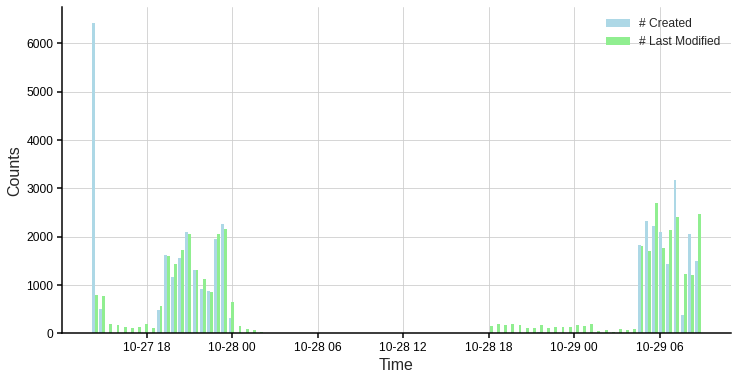

-------------------------------------------------------------


In [3]:
#!!!! BEGIN USER INPUT !!!!#
status = "new"
#!!!! END USER INPUT !!!!#
# # # Get calculation status and job distribution
calc_stat = current_box.get_calculation_status()
calc_dist = current_box.get_job_distribution(status)

# # # Print status of calculations
status_title = "Status of Calculations"
left_puffer = int((61 - len(status_title)) / 2)
right_puffer = left_puffer + 1
print(left_puffer * "-" + status_title + right_puffer * "-" + "\n")
for item in calc_stat.items():
    print("%15s %15s %15i %15s" % (" ", item[0], item[1], " "))
print(61 * "-")
# # # Print calculation distribution nicely
dist_title = "Distribution of " + status + " Calculations"
left_puffer = int((61 - len(dist_title)) / 2)
right_puffer = left_puffer + 1
print(left_puffer * "-" + dist_title + right_puffer * "-" + "\n")
for item in calc_dist.items():
    print("%30s %15i %15s" % (item[0], item[1], " "))
print(61 * "-")

# # # Plot histogramm of calculations, when they were created and last touched
current_box.plot_overview_calculations(bin_size=0.5)
print(61 * "-")

#### Summary of Compounds

Show summary of compounds exploration, when they were discovered and last touched by a puffin touched. 

Number of Compounds: 1420


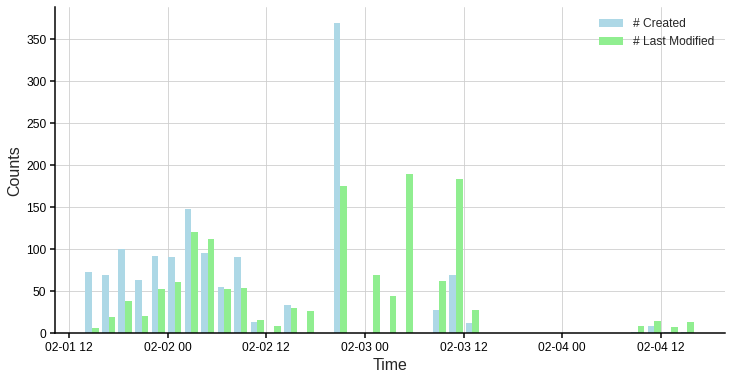

In [16]:
# # # Plot discovery of compounds and the total number of compounds
current_box.plot_overview_compounds(2.0)

#### Show Reactions

List the last 10 reaction equations of the current exploration in a simple string representation.

In [15]:
rxn_list = reactions.query_reactions(json.dumps({"elementary_steps": {"$exists": True}}))
compound_list = compounds.query_compounds(json.dumps({"structures": {"$exists": True}}))

n_reactions = len(rxn_list)
show_rxn = 10

# # # Loop over reaction
for index, cool_id in enumerate(rxn_list):
    if index > (n_reactions - show_rxn):
        print(61 * "-")
        print("Rxn ID:\t" + cool_id.id().string())
        print(current_box.get_reaction_equation(cool_id.id()))
        results = current_box.get_reaction_profile(cool_id.id(), "gibbs_free_energy")
        results_kJ = results[0] * utils.KJPERMOL_PER_HARTREE
        print(
            "%8s %6.2f %12s %6.2f %12s %6.2f"
            % ("Forward:", results_kJ[0], "Backward:", results_kJ[1], "RxnEnergy:", results_kJ[2])
        )
        print("Energy Mode:\t" + results[1])
        print(61 * "-")

-------------------------------------------------------------
Rxn ID:	601beab12a814a7ecd1e5de5
H2O(c:0, m:1) + H5I2O4(c:1, m:1) = HO(c:0, m:2) + H2O(c:1, m:2) + H3IO3(c:0, m:1) + HI(c:0, m:1)
Forward: 256.88    Backward: -552.34   RxnEnergy: 809.21
Energy Mode:	gibbs_free_energy
-------------------------------------------------------------
-------------------------------------------------------------
Rxn ID:	601beab92a814a7ecd1e5de6
H2O(c:0, m:1) + H3I3O4(c:0, m:1) = H2O(c:0, m:1) + H3I3O4(c:0, m:1)
Forward:  20.96    Backward:  20.96   RxnEnergy:   0.00
Energy Mode:	gibbs_free_energy
-------------------------------------------------------------
-------------------------------------------------------------
Rxn ID:	601beabb2a814a7ecd1e5de7
H2O(c:0, m:1) + H3I3O4(c:0, m:1) = H3IO3(c:0, m:1) + H2I2O2(c:0, m:1)
Forward:  67.41    Backward:   7.44   RxnEnergy:  59.97
Energy Mode:	gibbs_free_energy
-------------------------------------------------------------
--------------------------------

#### Detailed Rxn View

Obtain more information on one specific reaction, given by its ID as string.
This includes the reaction equation, the energy profile as well as the graph representation obtained by molassembler of every involved compound and its frequencies (in $\mathrm{cm^{-1}}$).

-------------------------------------------------------------
Rxn ID:	5f9a6a512a814a38cb30d772
H4I2O2(c:0, m:1) + H2(c:0, m:1) = H4I2O2(c:0, m:1) + H(c:0, m:2) + H(c:0, m:2)

Rxn Profile [kJ/mol] - electronic_energy
Forward: 103.26    Backward: -410.61   RxnEnergy: 513.86

Reagents:



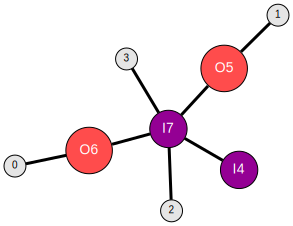

Compound ID: 5f981cd72a814a205d2c5cf1
Frequencies [cm^-1]: [  85.48175324  169.76963528  184.15534268  218.88675604  307.58984793
  323.6196532   427.70996202  486.26135587  566.87302015  747.87068551
  775.9739677   864.18347268  912.11351573 1049.73939114 1764.22614066
 2167.70457711 3693.21764299 3696.10804983]


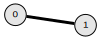

Compound ID: 5f981ceb2a814a205d2c5cf7
Frequencies [cm^-1]: [3753.66751071]

-------------------------------------------------------------

Products:



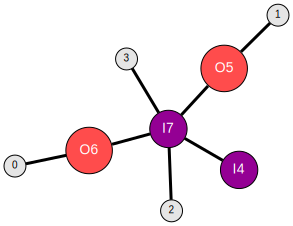

Compound ID: 5f981cd72a814a205d2c5cf1
Frequencies [cm^-1]: [  85.48175324  169.76963528  184.15534268  218.88675604  307.58984793
  323.6196532   427.70996202  486.26135587  566.87302015  747.87068551
  775.9739677   864.18347268  912.11351573 1049.73939114 1764.22614066
 2167.70457711 3693.21764299 3696.10804983]


Compound ID: 5f9a366f2a814a38c530d78a
Frequencies [cm^-1]: None


Compound ID: 5f9a366f2a814a38c530d78a
Frequencies [cm^-1]: None


In [6]:
#!!!! BEGIN USER INPUT !!!!#
# # # Enter the Rxn ID as string # # #
rxn_id = rxn_list[-10].id().string()  # "5f9a6c592a814a38cb30d77b"
#!!!! END USER INPUT !!!!#

# # # Obtain and link reaction
rxn_of_interest = reactions.get_reaction(db.ID(rxn_id))
rxn_of_interest.link(reactions)

# # # Print reaction id and profile
print(61 * "-")
print("Rxn ID:\t" + rxn_of_interest.id().string())
print(current_box.get_reaction_equation(rxn_of_interest.id()))
results = current_box.get_reaction_profile(rxn_of_interest.id(), "gibbs_free_energy")
results_kJ = results[0] * utils.KJPERMOL_PER_HARTREE
print("\nRxn Profile [kJ/mol] - " + results[1])
print(
    "%8s %6.2f %12s %6.2f %12s %6.2f"
    % ("Forward:", results_kJ[0], "Backward:", results_kJ[1], "RxnEnergy:", results_kJ[2])
)

# # # Print graph representation of reactants and their frequencies
for side in [0, 1]:
    if side == 0:
        print("\nReagents:\n")
    else:
        print("\n" + 61 * "-")
        print("\nProducts:\n")
    n_molecules = len(rxn_of_interest.get_reactants(db.Side.BOTH)[side])
    for compound in range(0, n_molecules):
        tmp_reactant_id = rxn_of_interest.get_reactants(db.Side.BOTH)[side][compound]
        tmp_reactant = compounds.get_compound(tmp_reactant_id)
        tmp_struct = current_box._get_first_structure_of_compound(tmp_reactant)
        current_box.display_masm_cbor_graph(tmp_struct.get_graph("masm_cbor_graph"))
        print("Compound ID:", tmp_reactant_id.string())
        print("Frequencies [cm^-1]:", current_box._get_frequencies(tmp_struct))

#### Query by SMILES

The compounds of your exploration are searched for a given molecule. The molecule itself is encoded as SMILES. The query will look for compounds with same bonding, then shape and finally being completely identical.

Same shape:
Compound ID: 6017f8372a814a580e36342a


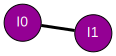

In [17]:
smiles_str = "II"

query_result = current_box.query_structures_by_smiles(smiles_str)

for item in query_result.items():

    for compound_id in item[1]:
        print("Same " + item[0] + ":")
        print("Compound ID: " + compound_id.string())
        compound = compounds.get_compound(compound_id)
        tmp_struct = current_box._get_first_structure_of_compound(compound)
        current_box.display_masm_cbor_graph(tmp_struct.get_graph("masm_cbor_graph"))

#### Query by Reference .mol File

The compounds of your exploration are searched for a list of given molecules. The molecules itself are encoded in a '.mol' file, with additional information about its charge and multiplicity in the third line of the file as '{ "charge": 0, "multiplicity": 1 }'.
The reference structure should be calculated with exactly the same method which you are using for your exploration.
Upon hits, the ID of the corresponding compound, the graph representation as well as the frequencies are shown.


-------------------------------------------------------------
Compound ID: 60184a952a814a097c463f59


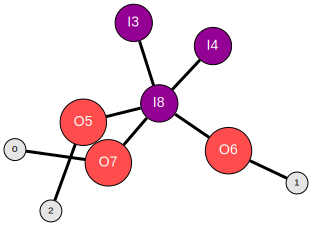

Frequencies [cm^-1]: [  72.28208987   77.86526916  139.44796519  151.44895641  167.1354598
  182.09291117  200.62983834  212.00368871  235.73380254  247.37815086
  261.60734944  305.79575436  434.87362317  491.87471001  526.90966821
  801.26942542  838.53639507  856.50060956 3620.26117658 3629.70458026
 3658.39359198]
-------------------------------------------------------------
Compound ID: 601843092a814a097c46399f


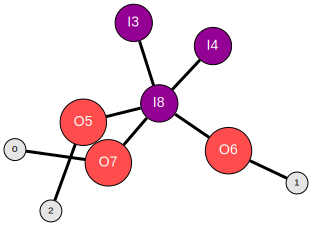

Frequencies [cm^-1]: [  50.91732041  109.12970178  125.11297206  152.76593808  178.85616235
  194.69156357  195.39181996  212.03741628  242.84744946  255.95695374
  298.05332081  346.03872772  452.36447092  480.5252777   535.88720122
  807.47860084  835.32480045  857.3541658  3645.36547886 3670.50523928
 3681.70856486]
-------------------------------------------------------------
Compound ID: 601838b72a814a097c46325a


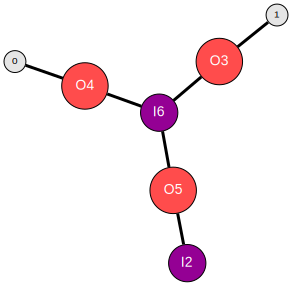

Frequencies [cm^-1]: [  75.70894882   78.64018899  161.72304682  192.27865493  250.13518677
  268.33509863  314.09598929  410.6427582   522.76355893  564.85950306
  612.84656734  891.21622707  957.7723407  3592.8177417  3612.39886564]
-------------------------------------------------------------
Compound ID: 6017f84b2a814a580e36342c


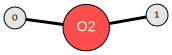

Frequencies [cm^-1]: [1539.28227164 3644.22205688 3652.44434088]
-------------------------------------------------------------
Compound ID: 6017f8a52a814a580e36343e


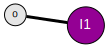

Frequencies [cm^-1]: [2370.96939457]
-------------------------------------------------------------
Compound ID: 601819702a814a097c461edb


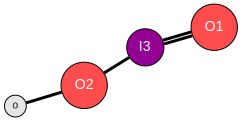

Frequencies [cm^-1]: [ 153.32947755  266.96361543  514.15281026  790.55742098  956.85256637
 3555.17473506]
-------------------------------------------------------------
Compound ID: 6019a6be2a814a3cb4784508


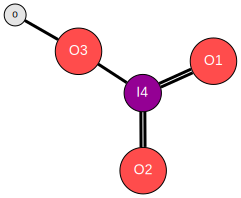

Frequencies [cm^-1]: [-100.00941704  243.81772864  275.0914581   287.53029167  501.12529993
  838.64901517  840.13835229  873.11753213 3524.81449983]
-------------------------------------------------------------
Compound ID: 6017f8372a814a580e36342a


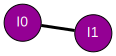

Frequencies [cm^-1]: [253.00963889]
-------------------------------------------------------------
Compound ID: 60181ad82a814a097c461f76


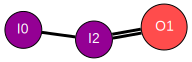

Frequencies [cm^-1]: [159.30681901 221.20133478 776.20491005]
-------------------------------------------------------------
Compound ID: 601817cc2a814a097c461e42


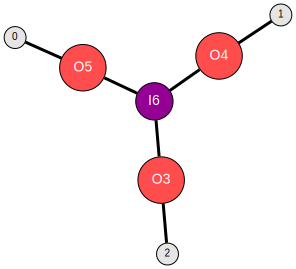

Frequencies [cm^-1]: [-259.74830059  130.94292215  211.5858566   240.32614469  250.97672247
  310.37155002  459.17244854  489.85684442  557.59771608  831.01045497
  876.25097599  971.93169747 3603.5074139  3637.36957305 3643.47230859]
-------------------------------------------------------------
Compound ID: 6017f8a52a814a580e36343f


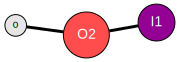

Frequencies [cm^-1]: [ 556.76681219 1033.21419232 3588.34967723]
-------------------------------------------------------------
Compound ID: 6017fbee2a814a580e363589


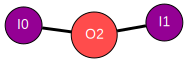

Frequencies [cm^-1]: [115.25171744 434.15148093 521.11920698]
-------------------------------------------------------------
Compound ID: 601841512a814a097c46383f


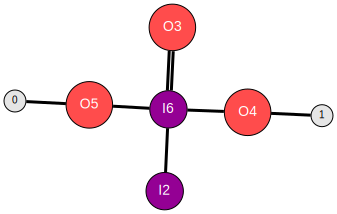

Frequencies [cm^-1]: [ 103.15826578  133.21984537  198.28549455  220.20414216  254.91732263
  295.61775303  339.63563329  421.34042934  458.36618738  552.35053505
  837.00805224  845.81881849  897.66849781 3589.26957844 3688.40846019]
-------------------------------------------------------------
Compound ID: 6019a4cd2a814a3cb478446e


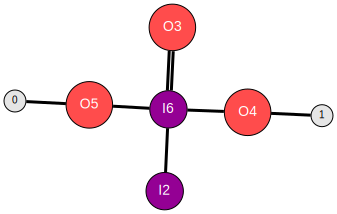

Frequencies [cm^-1]: [  93.87521902  140.55192073  169.31421549  222.02352684  241.55253991
  258.26201818  315.30661805  345.08050989  446.18941498  487.55557374
  818.40715663  830.17473478  837.12319255 3632.93609564 3641.63795246]


In [30]:
#!!!! BEGIN USER INPUT !!!!#
# # # Enter the relative path to the directory containing the .mol files of interest# # #
ref_dir = "ref_compounds_mol_xtb/"
#!!!! END USER INPUT !!!!#

result_dict = current_box.query_structures_by_mol_references(ref_dir)

for item in result_dict.items():
    print(61 * "-")
    print("Compound ID: " + item[1].string())
    tmp_struct = current_box._get_first_structure_of_compound(compounds.get_compound(item[1]))
    current_box.display_masm_cbor_graph(item[0])
    freq = current_box._get_frequencies(tmp_struct)
    print("Frequencies [cm^-1]:", freq)